In [72]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Main process for dealing with MainDataset

In this notebook, we are going to apply our pipeline constructed with the TestDataset in "KORSDC_FGremove/main/Reproducibility_part1_with_TestDataset.ipynb" to the beam corrected & point-source-removed cube. (Please see "KORSDC_FGremove/main/Reproducibility_part2_with_SE.py")


# Contents
1. Read inputs including the Beam-corrected & point-source-removed MainDataset
2. Densityflux to brightness temperature
3. Cut to 3x3 deg^2
4. Smoothing
5. ICA for foreground removal as well as PSF
6. Seperate 901 frequency bins into 6 as requested by SDC3 team
7. Measure Pk
8. Save the Pk as it is required from SDC3 team

In [73]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.cosmology import FlatLambdaCDM

In [74]:
#================= Define the path to the package
dir_path = '/home/minjioh/KORSDC_FGremove/'
#================= Define the path to the package

In [75]:
import sys
sys.path.append(dir_path+"tools")
from tools import RA_DEC_fq 
from tools import pk_3D_to_2D 
from tools import DensityFlux_to_Temp 

In [76]:
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import FastICA

# 1. Read inputs including the Beam-corrected & point-source-removed MainDataset

In [77]:
filename = dir_path+'ancillary/bins_kper.txt'
kper = np.loadtxt(filename)

filename = dir_path+'ancillary/bins_kpar.txt'
kpar = np.loadtxt(filename)

filename = dir_path+'ancillary/TestDatasetTRUTH_166MHz-181MHz.data'
Truth = np.loadtxt(filename)

In [78]:
########## Read the output from the Source Extractor HERE########## 
### Run "main/Reproducibility_part2_with_SE.py" for the output ###
path_sub = '/home/minjioh/SDC3/MainDataset/SExtractor/source_sub_cube_BS20_BF1.fits'
# path_sub = dir_path + '/output/source_sub_cube_BS20_BF1.fits'
print("Reading... ", path_sub)
fx = fits.open(path_sub)
print(fx.info())
########## Read the output from the Source Extractor HERE########## 

Reading...  /home/minjioh/SDC3/MainDataset/SExtractor/source_sub_cube_BS20_BF1.fits
Filename: /home/minjioh/SDC3/MainDataset/SExtractor/source_sub_cube_BS20_BF1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      66   (899, 899, 901)   float32   
None


# 2. Densityflux to brightness temperature

In [79]:
RA, DEC, fq = RA_DEC_fq(fx)
cart_map = DensityFlux_to_Temp(fx)
print(cart_map.shape)
print(RA.shape)
print(DEC.shape)
print(fq.shape)
del fx

RA range      : -2.00 to 2.00
DEC range     : -32.00 to -28.00
redshift range: 6.24 to 12.40
This is new
(901, 899, 899)
(899,)
(899,)
(901,)


# 3. Cut to 3x3 deg^2

In [80]:
TEST = abs(RA)< 1.5 # deg
RA_min = np.where(TEST==True)[0][0]
RA_max = np.where(TEST==True)[0][-1]+1

Image_3x3 = cart_map[:,RA_min:RA_max,RA_min:RA_max]
RA_3x3 = RA[RA_min:RA_max]
DEC_3x3 = DEC[RA_min:RA_max]

print(Image_3x3.shape)
print(RA_3x3.shape)
print(DEC_3x3.shape)
print(fq.shape)

del cart_map
del RA
del DEC

(901, 675, 675)
(675,)
(675,)
(901,)


In [81]:
RA_3x3[337] # 0~ 674, centered well!

0.0

data shape to be plotted:  (675, 675)
min/max of the pixel values:  -336.87913144597917 510.01465159972236
mean= 22.560127010049975
std= 127.5943314251425
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -308.13364843203044 456.41987084164515
mean= 19.34378031799189
std= 115.62230549277352
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -281.4408602803484 413.6270798367597
mean= 18.44692443669992
std= 105.11406380372054
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -253.61438680615208 384.5839538788727
mean= 16.237220600908426
std= 95.79951565546483
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -236.56914031038687 347.79841078754214
mean= 12.882554348744339
std= 87.66032395596038
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -217.4503020646432 316.588489574233
mean= 11.675858456035778
std= 80.33116121814659


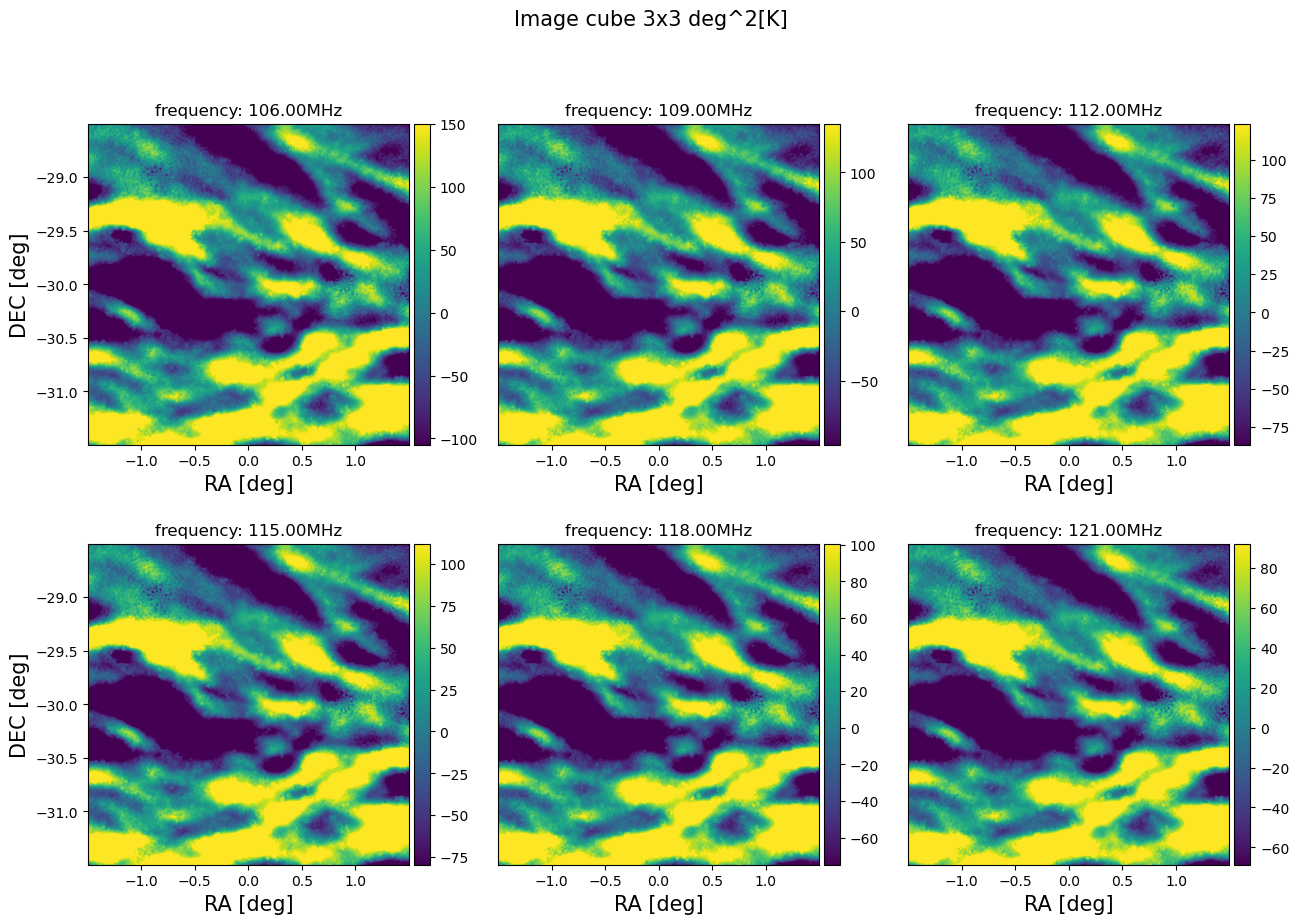

In [82]:
sample=np.array([0, 30, 60, 90, 120, 150])

plt.figure(figsize=(15,10))
ithf=0
plt.suptitle("Image cube 3x3 deg^2[K]",fontsize=15)
for ithf in range(6):
    plt.subplot(2,3,1+ithf)
    plt.title("frequency: {:.2f}MHz".format(fq[sample][ithf]))

    ax = plt.gca()
    myMatrix =Image_3x3[sample][ithf]

    print("data shape to be plotted: ", myMatrix.shape)
    print("min/max of the pixel values: ",np.min(myMatrix), np.max(myMatrix))

    vmin=np.std(myMatrix)
    vmean=np.mean(myMatrix)
    print("mean=", vmean)
    print("std=", vmin)
    im = plt.imshow(myMatrix,extent=([min(RA_3x3), max(RA_3x3), min(DEC_3x3), max(DEC_3x3)]),vmin=vmean-vmin,vmax=vmean+vmin)
    plt.xlabel("RA [deg]",fontsize=15)
    if ithf==0 or ithf==3:
        plt.ylabel("DEC [deg]",fontsize=15)
    else:
        plt.yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im,cax=cax)

# 4. Smoothing

In [83]:
fq0 = 181.

sigma0 = 3
sigma_filter = np.zeros(Image_3x3.shape[0])

for i in range(Image_3x3.shape[0]):
    sigma_filter[i] = sigma0*(fq0/fq[i])

In [84]:
f_slice_smooth = np.zeros(Image_3x3.shape)
for i in range(Image_3x3.shape[0]):
    f_slice_smooth[i] = gaussian_filter(Image_3x3[i], sigma=sigma_filter[i])

# 5. ICA for foreground removal as well as PSF

In [85]:
total_pixels = f_slice_smooth.shape[1]*f_slice_smooth.shape[2]
flattened_data = np.reshape(f_slice_smooth,(f_slice_smooth.shape[0],total_pixels))

/home/minjioh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/home/minjioh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guida

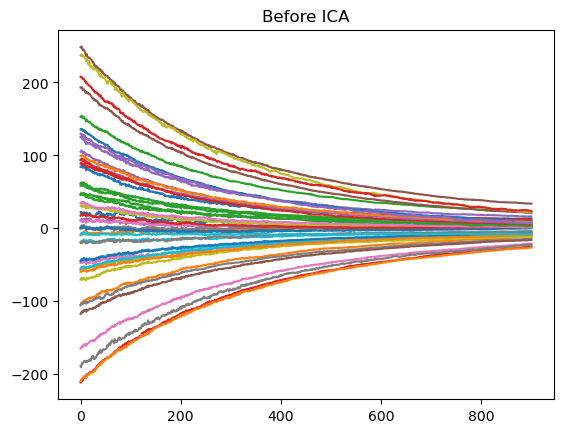

In [86]:
num_sub_samples = np.int(np.floor(np.float(total_pixels)/10000.0))
plt.title("Before ICA")
for i in range(0,num_sub_samples):
    plt.plot(flattened_data[:,i*10000])

In [87]:
n_components = 4 # 1 component for PSF + 3 component for foreground
ica = FastICA(n_components=n_components)
S_ = ica.fit_transform(flattened_data.T)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

/home/minjioh/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


In [88]:
print(flattened_data.shape,A_.shape,S_.shape,ica.mean_.shape)

(901, 455625) (901, 4) (455625, 4) (901,)


In [89]:
num_freq_bins = f_slice_smooth.shape[0]

In [90]:
ica_map = np.dot(S_, A_.T) + ica.mean_

diff_map = np.zeros([num_freq_bins,total_pixels])
for i_freq in range(0,num_freq_bins):
    diff_map[i_freq,:] = flattened_data[i_freq,:] - ica_map[:,i_freq]
    
diff_map_ra_dec = np.reshape(diff_map,(f_slice_smooth.shape[0],f_slice_smooth.shape[1],f_slice_smooth.shape[2]))

/home/minjioh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/home/minjioh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guida

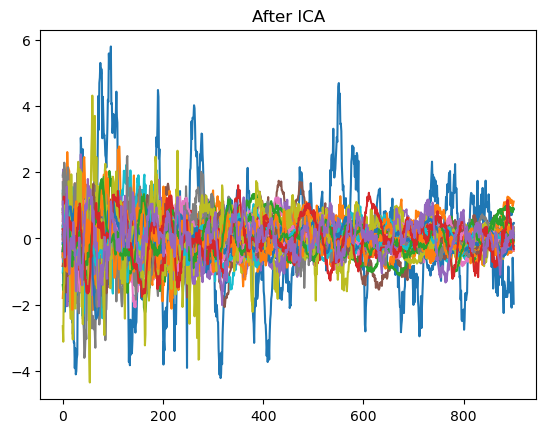

In [91]:
num_sub_samples = np.int(np.floor(np.float(total_pixels)/10000.0))
plt.title("After ICA")

for i in range(0,num_sub_samples):
    plt.plot(diff_map[:,i*10000])

data shape to be plotted:  (675, 675)
min/max of the pixel values:  -11.255676445116464 12.442393558919221
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -8.929369363165051 14.30512857765001
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -7.363424408480263 7.955390214092819
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -10.511606122434529 5.583181797102199
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -7.908590464883659 12.440678262543258
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -10.809923144907687 6.515720864509319


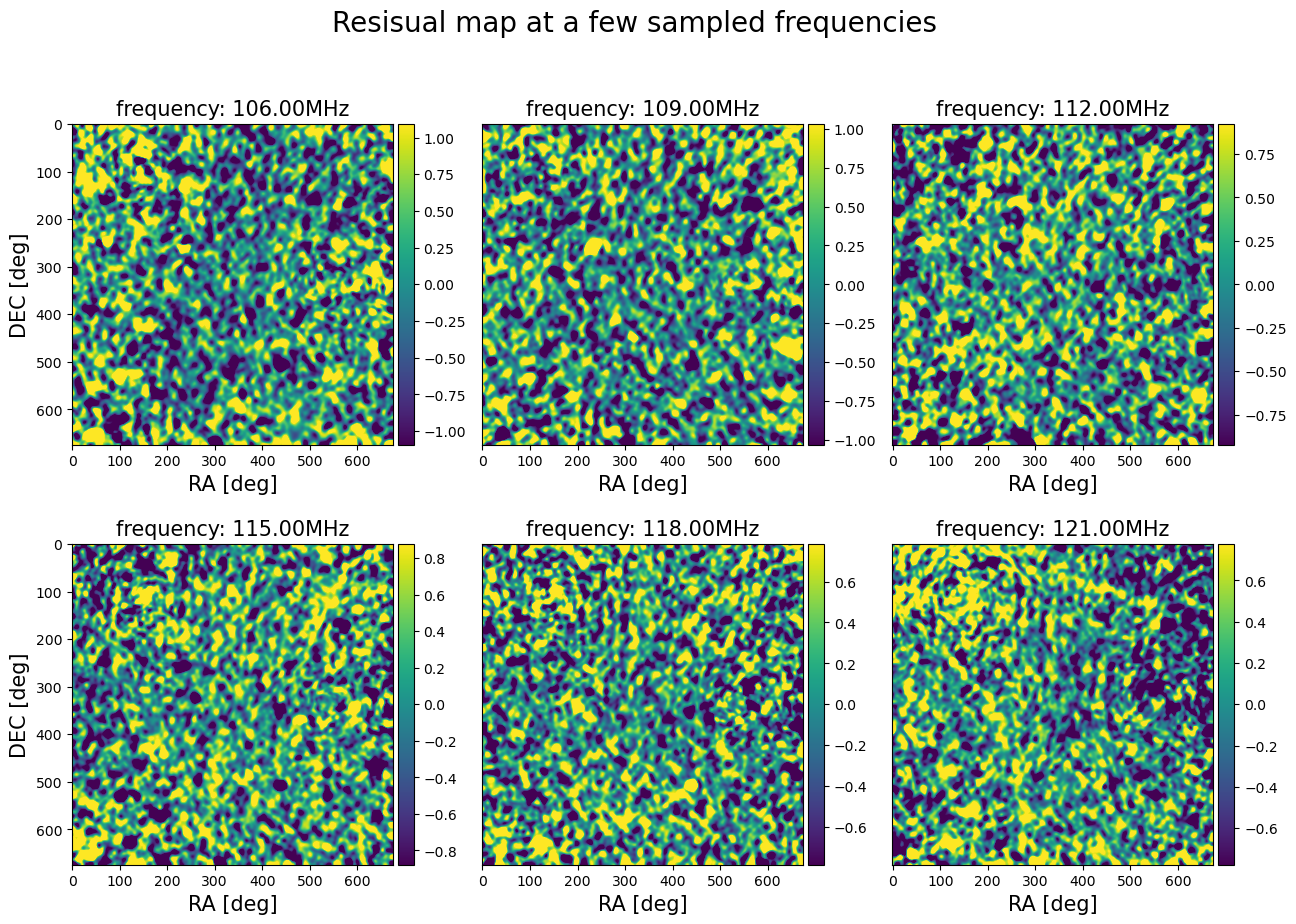

In [92]:
plt.figure(figsize=(15,10))
plt.suptitle("Resisual map at a few sampled frequencies",fontsize=20)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.title("frequency: {:.2f}MHz".format(fq[sample[i]]),fontsize=15)
    
    ax = plt.gca()
    
    print("data shape to be plotted: ", diff_map_ra_dec[sample[i]].shape)
    print("min/max of the pixel values: ",np.min(diff_map_ra_dec[sample[i]]), np.max(diff_map_ra_dec[sample[i]]))

    myMatrix =diff_map_ra_dec[sample[i]]
    vmin=np.std(myMatrix)
    vmean=np.mean(myMatrix)
    im = plt.imshow(myMatrix,vmin=vmean-vmin,vmax=vmean+vmin)
    plt.xlabel("RA [deg]",fontsize=15)
    if i==0 or i==3:
        plt.ylabel("DEC [deg]",fontsize=15)
    else:
        plt.yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im,cax=cax)
plt.show()

# 6. Seperate 901 frequency bins into 6 as requested by SDC3 team

In [93]:
filename = dir_path + '/ancillary/bins_frequency.txt'
fmin, fmax = np.loadtxt(filename,skiprows=3,unpack=True)

In [94]:
f_slice = {}
fq_slice = {}
for j in range(6):
    if j !=5:
        TEST = (fq>=fmin[j]) & (fq<fmax[j])
    else:
        TEST = (fq>=fmin[j]) & (fq<=fmax[j])
    f_slice[j] = diff_map_ra_dec[TEST]
    fq_slice[j] = fq[TEST]

    print(f_slice[j].shape, fmin[j], fmax[j], np.mean(fq_slice[j]))

(150, 675, 675) 106.0 121.0 113.45
(150, 675, 675) 121.0 136.0 128.45
(150, 675, 675) 136.0 151.0 143.45
(150, 675, 675) 151.0 166.0 158.45
(150, 675, 675) 166.0 181.0 173.45
(151, 675, 675) 181.0 196.0 188.5


# 7. Measure Pk

In [95]:
pk2 = {}
nk2 = {}
for j in range(6):
    ft = np.fft.fftn(f_slice[j].astype('float64'))
    Tk = np.fft.fftshift(ft)
    del ft

    pk2[j], nk2[j] = pk_3D_to_2D(kper,Tk,RA_3x3,fq_slice[j])

(10,)
(150, 675, 675)
(675,)
(150,)
   352.080840143443  Mpc
   199.82596729377565  Mpc
(10,)
(150, 675, 675)
(675,)
(150,)
   341.89806715338494  Mpc
   187.744537697743  Mpc
(10,)
(150, 675, 675)
(675,)
(150,)
   332.2961420071942  Mpc
   177.59936589045537  Mpc
(10,)
(150, 675, 675)
(675,)
(150,)
   323.186900977813  Mpc
   168.9171346697658  Mpc
(10,)
(150, 675, 675)
(675,)
(150,)
   314.50274013780376  Mpc
   161.37146310023945  Mpc
(10,)
(151, 675, 675)
(675,)
(151,)
   306.1905076561964  Mpc
   155.74684771415832  Mpc


# 8. Save the Pk as it is required from SDC3 team

In [96]:
for j in range(6):
    filename = dir_path + 'output/teamKorSDC_{:.1f}MHz-{:.1f}MHz.data'.format(fmin[j],fmax[j])
    np.savetxt(filename,pk2[j]/3.)

    filename = dir_path + 'output/teamKorSDC_{:.1f}MHz-{:.1f}MHz_errors.data'.format(fmin[j],fmax[j])
    np.savetxt(filename,(pk2[j]/3.)/np.sqrt(nk2[j]))

- Note that factor "3" is divided which is found by comparing the Truth and the TestDataset here:

KORSDC_FGremove/main/Reproducibility_part1_with_TestDataset.ipynb

# Now, you may want to check how much these outputs are consistent with the truth! The truth is revealed here:
KORSDC_FGremove/Answers_revealed/Answers_revealed.ipynb